# ADL classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns

import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, LSTM, CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json

RANDOM_SEED = 42

Using TensorFlow backend.


In [43]:
inputData = 'data/jrp/jrp_Data_test.txt'
numberOfTotalClasses = 5

In [44]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv(inputData, header = None, names = columns)
df = df.dropna()

In [45]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.set_ylim((-100, 100))
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

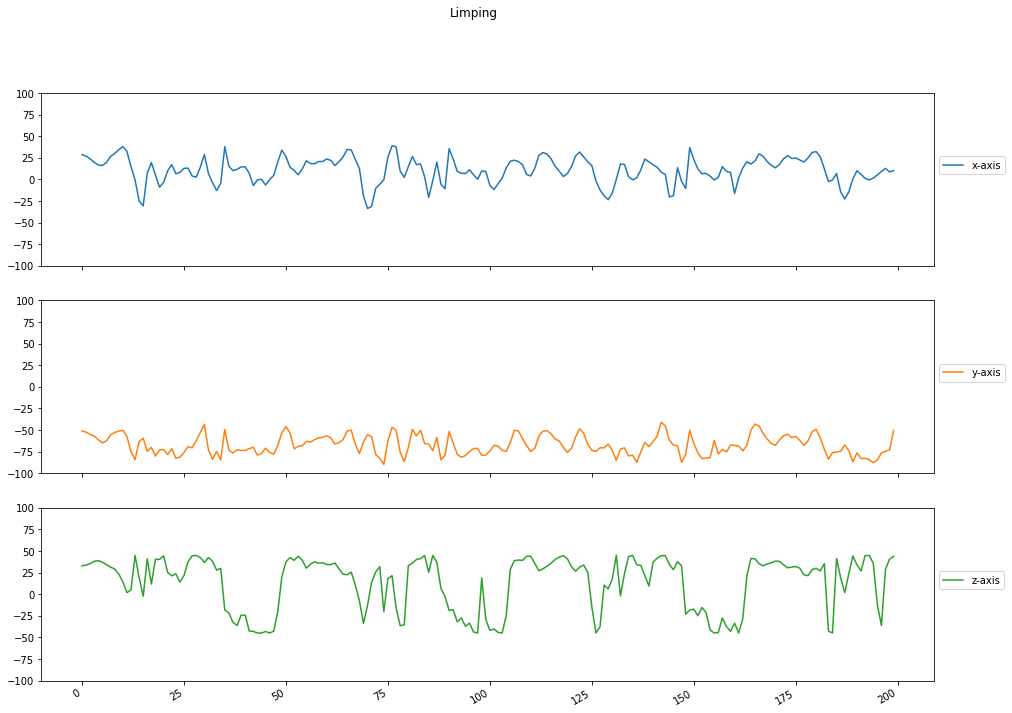

In [9]:
plot_activity("Limping", df)

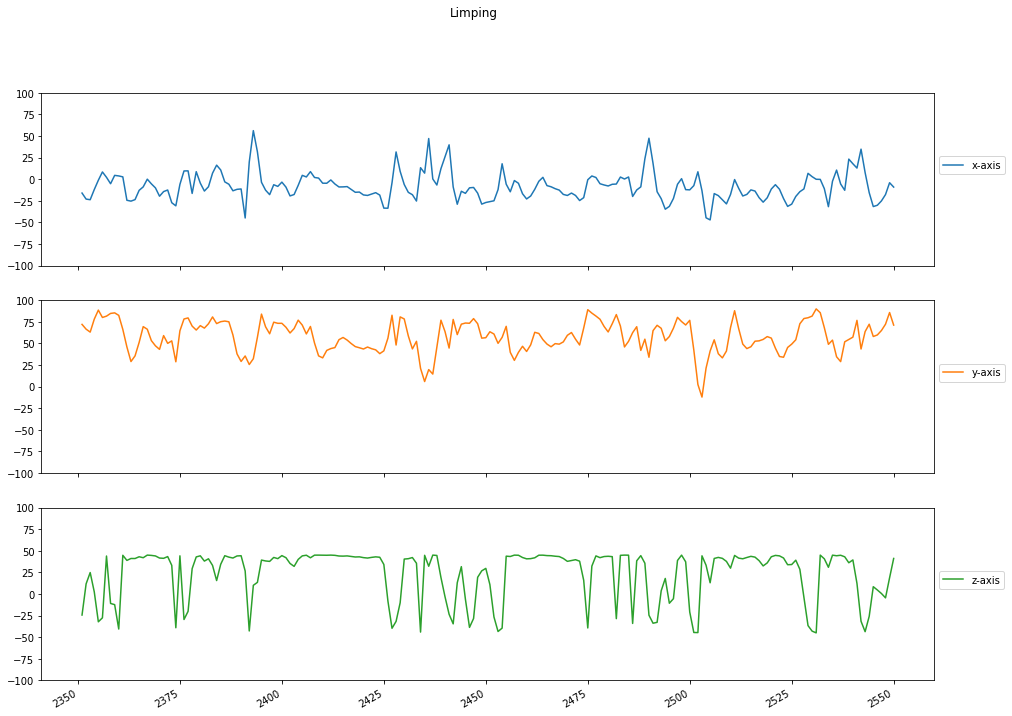

In [46]:
plot_activity("Limping", df)

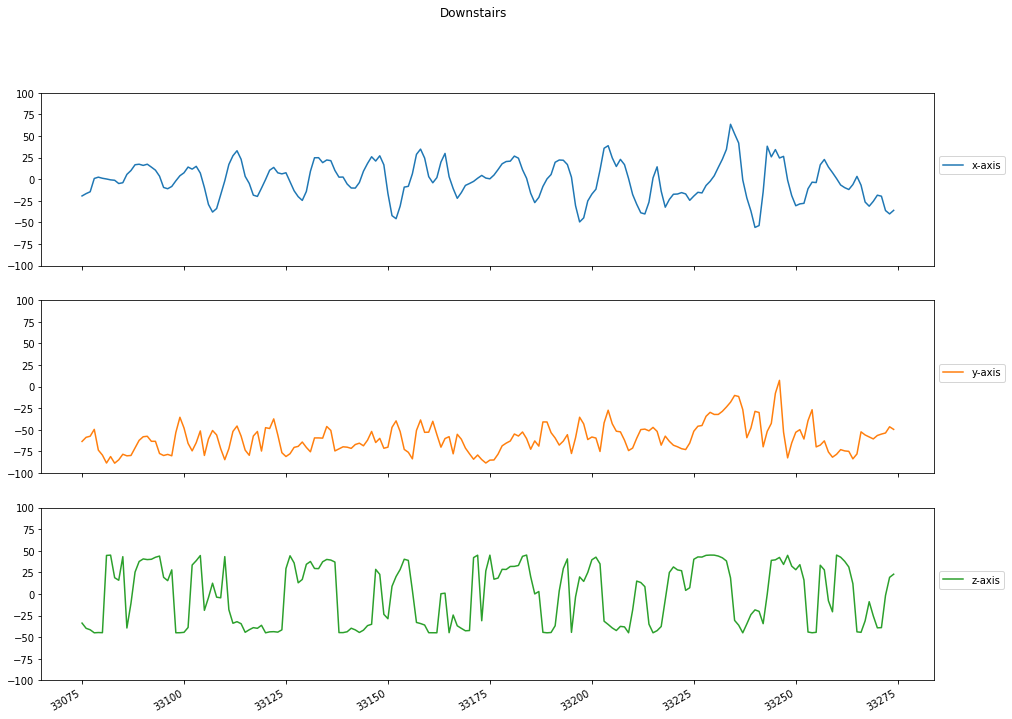

In [13]:
plot_activity("Downstairs", df)

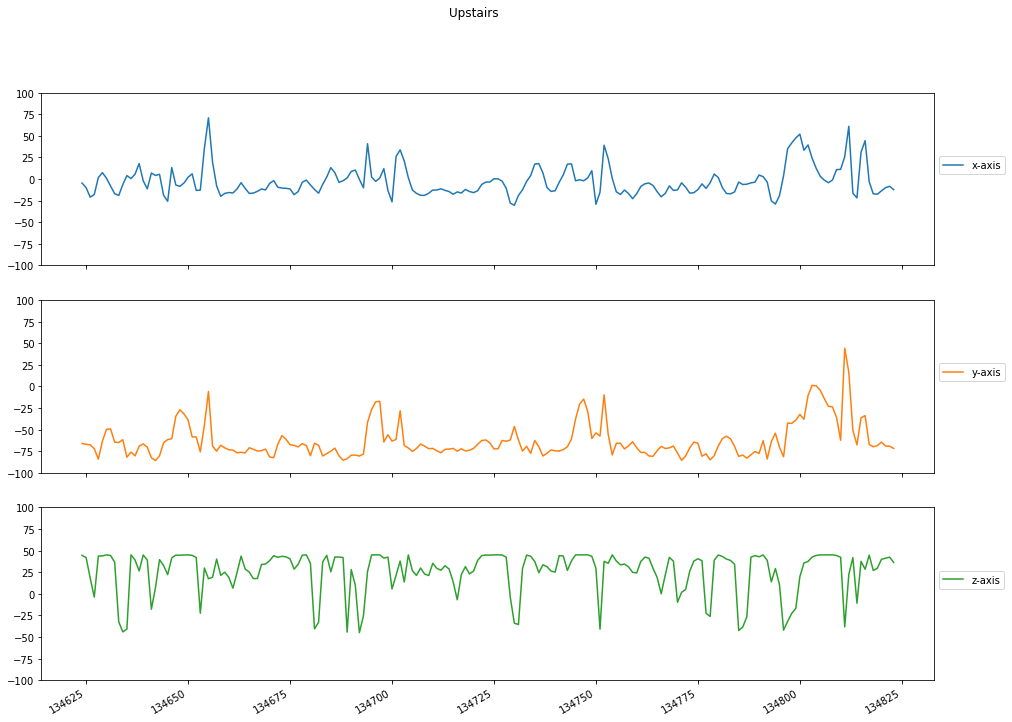

In [12]:
plot_activity("Upstairs", df)

In [14]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/home/vtpc/.local/lib/python2.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [15]:
temp_segments = np.asarray(segments, dtype= np.float32)
reshaped_segments = np.zeros((temp_segments.shape[0],200, 3))
for i in range(0, temp_segments.shape[0], 1):
    reshaped_segments[i] = temp_segments[i].T
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))


(11297, 200, 3)
(2825, 200, 3)
(11297, 5)
(2825, 5)


In [20]:
N_CLASSES = numberOfTotalClasses //5
N_EPOCHS = 15
BATCH_SIZE = 32

In [21]:
history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

model = Sequential()

model.add(Conv1D(input_shape=(N_TIME_STEPS, N_FEATURES), filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(Dense(512))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=True, dropout=0.5))  # returns a sequence of vectors of dimension 32
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True, dropout=0.5))  # returns a sequence of vectors of dimension 64
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=False, dropout=0.5))  # returns a sequence of vectors of dimension 128
model.add(BatchNormalization())

model.add(Dense(512))
model.add(BatchNormalization())

model.add(Dense(N_CLASSES, activation='softmax'))
print (model.summary())

optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_callback = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_split=0.2)

history['train_loss'] = history_callback.history["loss"]
history['train_acc'] = history_callback.history["acc"]
history['test_loss'] = history_callback.history["val_loss"]
history['test_acc'] = history_callback.history["val_acc"]


scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# serialize model to JSON
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/model.h5")
print("Saved model to disk")

#import uff
#print("Optimizing using tensorrt...")
#uff.from_tensorflow('models/model.h5', output_filename = "models/model.uff")
#print("Optimization done!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 199, 64)           448       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 99, 64)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 99, 64)            256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 98, 128)           16512     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 49, 128)           512       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 48, 256)           65792     
__________

In [26]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [29]:
from keras import backend as K

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "models", outputModel, as_text=False) 

INFO:tensorflow:Froze 402 variables.
INFO:tensorflow:Converted 402 variables to const ops.


'models/jrp2702.pb'

In [30]:
# import uff
# uff.from_tensorflow('models/model.pb', output_filename='models/model.uff')

In [31]:
with open('models/model.json', 'r') as f:
    model = model_from_json(f.read())
    
model.load_weights('models/model.h5')

In [32]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 99.86%


# Evaluation

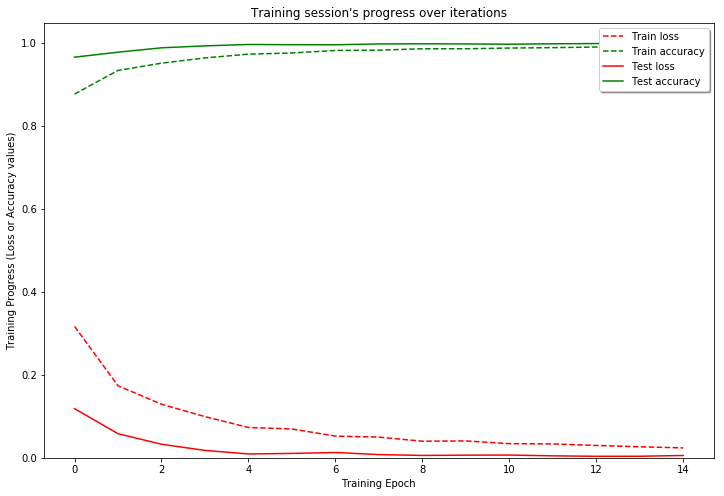

In [33]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [34]:
LABELS = ['Downstairs', 'Limping' , 'Standing','Upstairs', 'Walking']

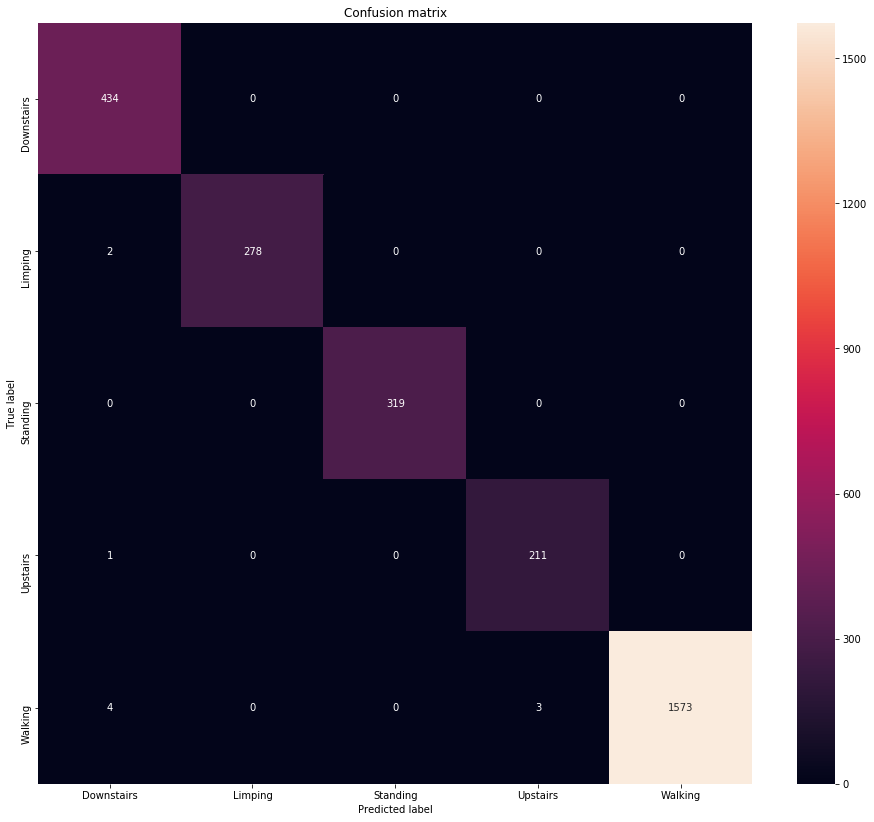

In [35]:
#y_test = np.expand_dims(y_test, axis=2) # reshape (569, 30) to (569, 30, 1) 
# now input can be set as 
#model.add(Conv1D(2,2,activation='relu',input_shape=(30, 1))

    
predictions = model.predict_classes(X_test)

#for x in X_test:
#    for j in x:
#        print(j[0],j[1],j[2])
#        print("-----------------------------")

max_test = np.argmax(y_test, axis=1)
#max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, predictions)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [36]:
for node in model.inputs:
    print(node)

Tensor("conv1d_4_input_1:0", shape=(?, 200, 3), dtype=float32)


In [37]:
for node in model.outputs:
    print(node)

Tensor("dense_6_1/Softmax:0", shape=(?, 5), dtype=float32)


In [42]:
#This is to test, if some other data is classified
testFile = 'data/jrp/jrp_Data_test.txt'


testColumns =['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
#testColumns =['timestamp', 'x-axis', 'y-axis', 'z-axis']
df_test = pd.read_csv(testFile, header = None, names = testColumns)
df_test = df_test.dropna()

xList = list(df_test['x-axis'])
yList = list(df_test['y-axis'])
zList = list(df_test['z-axis'])

counter = 1
correctCounter = 0;
for counter in range (1, 1000,1):
    xSublist = []
    ySublist = []
    zSublist = []
    segments_test = []

    for i in range(200*(counter-1),200*counter,1):
        xSublist.append(xList[i])
        ySublist.append(yList[i])
        zSublist.append(zList[i])

    segments_test.append([xSublist, ySublist, zSublist]) 
    temp_segments = np.asarray(segments_test, dtype= np.float32)
    reshaped_segments_test = np.zeros((temp_segments.shape[0],200, 3))

    for i in range(0, reshaped_segments_test.shape[0], 1):
        reshaped_segments_test[i] = temp_segments[i].T   
        #print(reshaped_segments_test[i][0][0], reshaped_segments_test[i][0][1], reshaped_segments_test[i][0][2])
    test_predictions = model.predict_classes(reshaped_segments_test)
    prediction = model.predict(reshaped_segments_test)
    
    downstairs = prediction[0][0]*100
    standing = prediction[0][1]*100
    upstairs = prediction[0][2]*100
    walking = prediction[0][3]*100
    limping = prediction[0][4]*100
    print("P:%s, O:%s, %.2f, %.2f, %.2f, %.2f, %.2f" % (LABELS[test_predictions[0]], df_test['activity'].iloc[200*counter-100] ,downstairs, standing, upstairs, walking, limping))
    if (downstairs<99 and standing<99 and upstairs<99 and walking<99 and limping<99):
        print("LAST ONE IS A BAD PREDICTION!")
    
    #print(reshaped_segments_test.shape)
    #if (LABELS[test_predictions[0]] == df_test['activity'].iloc[200*counter-100]):
    #    correctCounter = correctCounter + 1
    #print(counter, 200*(counter-1),200*counter, LABELS[test_predictions[0]], df_test['activity'].iloc[200*counter-100], correctCounter)
    #print(counter, 200*(counter-1),200*counter, LABELS[test_predictions[0]], correctCounter)
    #print(X_test.shape)

    #for x in range(0,4,1):
    #    number = mjau[0,x]*100
    #    print("%f" % number)

P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.98
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.03, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.03, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.98
P:Walking, O:Walking, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Limping, 0.00, 0.01, 0.00, 0.01, 99.97
P:Walking, O:Limping, 0.00, 0.00, 0.00, 0.02, 99.98
P:Walking, O:Limping, 0.00, 0.00, 0.00, 0.02, 99.98
P:Walking, O:Limping, 0.00, 0.01, 0.00, 0.02, 99.97
P:Walking, O:Limping, 0.00, 0.00, 0.00, 0.02, 99.97
P:Walking, O:Limping, 0.00, 0.01, 0.00, 0.02, 99.97


IndexError: list index out of range